In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_v, n_clust_obs_f_v_val, get_repeated_predictions, get_bootstrapped_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester_over_obs, plot_eces_over_obs_repeated

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [4]:
# Training steps
epochs=20 
iterations_per_epoch=1000

# Range of nested observations
n_obs_min = 1 
n_obs_max = 100

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:\\Users\\lasse\\Documents\\hierarchical_model_comparison_project\\checkpoints\\01_calibration_validation\\checkpoints_var_obs'

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Networks loaded from C:\Users\lasse\Documents\hierarchical_model_comparison_project\checkpoints\01_calibration_validation\checkpoints_var_obs\ckpt-20


# Train & validate

In [4]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, 
    n_obs=partial(n_clust_obs_f_v, n_obs_min, n_obs_max)
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# Get repeated predictions
n_settings = n_obs_max + 1 - n_obs_min
n_repetitions = 25
n_data_sets = 5000
n_models = 2

m_soft = np.zeros((n_settings, n_repetitions, n_data_sets, n_models))
m_true = np.zeros((n_settings, n_repetitions, n_data_sets, n_models))

for n in range(n_settings):
    for i in range(n_repetitions):
        m_val, _, x_val = simulator(n_data_sets, n_clust_obs_f_v_val(n+1))

        m_soft[n,i,:,:] = tf.concat([probability_net.predict(summary_net(x_chunk))['m_probs'] for x_chunk in tf.split(x_val, 20)], axis=0)
        m_true[n,i,:,:] = m_val
    
    if n%25 == 0:
        print('Iteration {} finished'.format(n))

Iteration 0 finished
Iteration 25 finished
Iteration 50 finished
Iteration 75 finished


In [5]:
# Export repeated predictions
export_preds = False

if export_preds==True:
    local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo

    filename_soft = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_m_soft')
    filename_true = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_m_true')
    val_folder = 'C:\\Users\\lasse\\Documents\\hierarchical_model_comparison_project\\data\\01_calibration_validation\\02_variable_observations'

    np.save(os.path.join(val_folder, filename_soft), m_soft)
    np.save(os.path.join(val_folder, filename_true), m_true)

In [5]:
# Import repeated predictions
import_preds = True

if import_preds==True:
    n_settings = n_obs_max + 1 - n_obs_min
    n_repetitions = 25
    n_data_sets = 5000
    n_models = 2

    filename_soft = '2022_12_15_m_soft.npy'
    filename_true = '2022_12_15_m_true.npy'
    val_folder = 'C:\\Users\\lasse\\Documents\\hierarchical_model_comparison_project\\data\\01_calibration_validation\\02_variable_observations'

    m_soft = np.load(os.path.join(val_folder, filename_soft))
    m_true = np.load(os.path.join(val_folder, filename_true))

Grand median ECE = 0.011592153501138094
Median accuracy = 0.8848


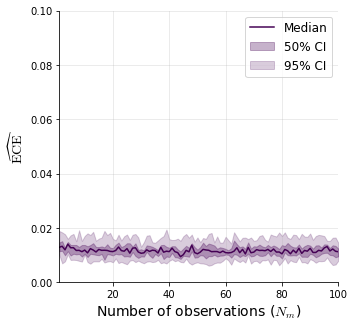

In [6]:
plot_eces_over_obs_repeated(m_true, m_soft, n_obs_min, n_obs_max, narrow_ci=[0.25, 0.75], 
                            wide_ci=[0.025, 0.975], n_repetitions=n_repetitions, print_accuracy=True, save=True)

# For publication: Plot together with calibration curve from calibration experiment 1

In [ ]:
# TODO if needed

In [3]:
# load network from calibration experiment 1

summary_net_1 = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net_1 = EvidentialNetwork(evidence_meta_validation)

amortizer_1 = MultiModelAmortizer(evidence_net_1, summary_net_1)

simulator_1 = MainSimulator(HierarchicalNormalSimulator())

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'checkpoints_fixed'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer_1, 
    checkpoint_path=checkpoint_path,
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\01_calibration_validation\checkpoints_fixed\ckpt-10


ECE = 0.041


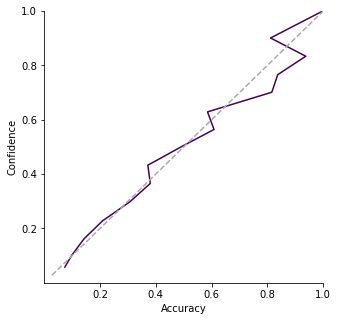

In [5]:
from src.python.helpers import n_clust_obs_f_f
from src.python.visualization import perf_tester

n_val_1 = 5000
m_val_1, _, x_val_1 = simulator_1(n_val_1, n_clust_obs_f_f())
val_data_1 = {'X' : x_val_1, 'm' : m_val_1}

perf_tester(evidence_net_1, summary_net_1, val_data_1, n_cal_bins=15, pub_style=True)

In [ ]:
import matplotlib as plt
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

# TODO: embed both figures into one subplot